<a href="https://colab.research.google.com/github/stewieboomhauer/roBERT/blob/main/%22Transformers_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-------------------------------------------------------
# **1. Installing Simple Transformers**
-------------------------------------------------------

In [ ]:
!pip install simpletransformers

-------------------------------------------------------
# **2. Loading created in Label Studio Data**
-------------------------------------------------------


In [ ]:
import simpletransformers
from simpletransformers.ner import NERModel,NERArgs
import json
import pandas as pd
import torch
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
import random
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import collections

#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sn
sn.set(color_codes=True)
# sn.set(font_scale=1)
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'


In [ ]:

with open('/content/drive/MyDrive/files/spacy_train.json', encoding='utf8') as json_file:
    train_data = json.load(json_file)


In [ ]:
with open('/content/drive/MyDrive/files/spacy_dev.json', encoding='utf8') as json_file:
    dev_data = json.load(json_file)

In [ ]:

with open('/content/drive/MyDrive/files/spacy_test.json', encoding='utf8') as json_file:
    evl_data = json.load(json_file)


-------------------------------------------------------
# **3. Preprocessing**
**3.1 Creating train-, dev- and test-datasets**
-------------------------------------------------------
-------------------------------------------------------

In [ ]:
sentence_train = {}
sentence_dev = {}
train_ner = []
dev_ner = []
count_train = 0
count_test = 0

for elem in train_data:
    for dicts in elem["paragraphs"]:
        for dictOfTokens in dicts["sentences"]:
            count_train = count_train + 1
            sentence_train["Sentence: " + str(count_train)] = []
            for annotation in dictOfTokens["tokens"]:
                for key, value in annotation.items():
                    if key == "orth":
                        sentence_train["Sentence: " + str(count_train)].append(value)
                    elif key == "ner":
                        train_ner.append(value)


df_train = pd.concat({k: pd.Series(v) for k, v in sentence_train.items()}).reset_index()
df_train.columns = ['sentence_id', 'del','words']
df_train['labels'] = train_ner
df_train.drop(columns=['del'], inplace=True, axis=1)


In [ ]:
for elem in dev_data:
    for dicts in elem["paragraphs"]:
        for dictOfTokens in dicts["sentences"]:
            count_test = count_test + 1
            sentence_dev["Sentence: " + str(count_test)] = []
            for annotation in dictOfTokens["tokens"]:
                for key, value in annotation.items():
                    if key == "orth":
                        sentence_dev["Sentence: " + str(count_test)].append(value)
                    elif key == "ner":
                        dev_ner.append(value)


df_dev = pd.concat({k: pd.Series(v) for k, v in sentence_dev.items()}).reset_index()
df_dev.columns = ['sentence_id', 'del','words']
df_dev['labels'] = dev_ner
df_dev.drop(columns=['del'], inplace=True, axis=1)



In [ ]:
count_evl = 0
sentence_test = {}
test_ner = []
list_true = []
tokens = []



for elem in evl_data:
    for dicts in elem["paragraphs"]:
        for dictOfTokens in dicts["sentences"]:
            count_evl = count_evl + 1
            sentence_test["Sentence: " + str(count_evl)] = []
            list_true.append([])
            for annotation in dictOfTokens["tokens"]:
                for key, value in annotation.items():
                    if key == "orth":
                        sentence_test["Sentence: " + str(count_evl)].append(value)
                        tokens.append(value)
                    elif key == "ner":
                        test_ner.append(value)

dict_true = dict(zip(tokens, test_ner))

new_dict_true = []

for k, v in dict_true.items():
  new_dict_true.append({k:v})


df_test = pd.concat({k: pd.Series(v) for k, v in sentence_test.items()}).reset_index()

df_test.columns = ['sentence_id', 'del','words']
df_test['labels'] = test_ner
df_test.drop(columns=['del'], inplace=True, axis=1)


texts = []
for elem in evl_data:
    for dicts in elem["paragraphs"]:
        for keys, text in dicts.items():
            if keys == "raw":
                texts.append(text)

text = []
for elem in texts:
  text.append(elem)


In [ ]:
df_test

,sentence_id,words,labels
0,Sentence: 1,\n\n,O
1,Sentence: 1,Who,O
2,Sentence: 1,'s,O
3,Sentence: 1,allowed,O
4,Sentence: 1,to,O
...,...,...,...
7645,Sentence: 465,was,O
7646,Sentence: 465,owned,O
7647,Sentence: 465,by,O
7648,Sentence: 465,Netflix,B-STUDIO


**3.2 Data Distribution**

In [ ]:
# A class to retrieve the sentences from the train_dataset
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["words"].values.tolist(),
                                                           s["labels"].values.tolist())]
        self.grouped = self.data.groupby("sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = getsentence(df_train)
sentences = getter.sentences 
print(sentences[0])

getter_test = getsentence(df_test)
sentences = getter_test.sentences



[('The', 'O'), ('problem', 'O'), ('with', 'O'), ('that', 'O'), ('movie', 'O'), ('was', 'O'), ('that', 'O'), ('it', 'O'), ('was', 'O'), ('a', 'O'), ('mediocre', 'O'), ('story', 'O'), ('.', 'O')]


In [ ]:
#Find the number of words in the train_data
words = list(set(df_train["words"].values))
n_words = len(words)
print(n_words)

#Find the number of words in the dev_data
words = list(set(df_dev["words"].values))
n_words = len(words)
print(n_words)

#Find the number of words in the test_data
words = list(set(df_test["words"].values))
n_words = len(words)
print(n_words)

6894
1606
1859


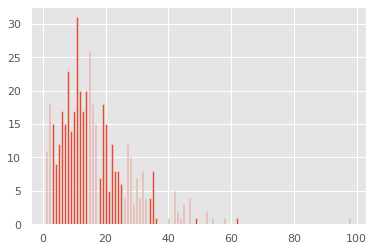

In [ ]:
#Visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=200)
plt.show()

In [ ]:
maxlen = max([len(s) for s in sentences])
minlen = min([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)
print ('Minimum sentence length:', minlen)

Maximum sentence length: 98
Minimum sentence length: 1


In [ ]:
df_train.loc[df_train['labels'] == 'B-STUDIO', 'words'].head()


29     Disney
47     Disney
55     Disney
57     Marvel
145    Warner
Name: words, dtype: object

In [ ]:
df_train.loc[df_train['labels'] == 'I-STUDIO', 'words'].head()


15963        Century
20662          Movie
25726       Pictures
25812    Searchlight
37896        Picture
Name: words, dtype: object

In [ ]:
df_train.loc[df_train['labels'] == 'L-STUDIO', 'words'].head()

522      Studios
826           TV
1809    Pictures
1998        Plus
2220       Prime
Name: words, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


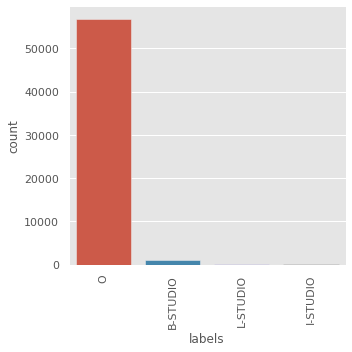

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


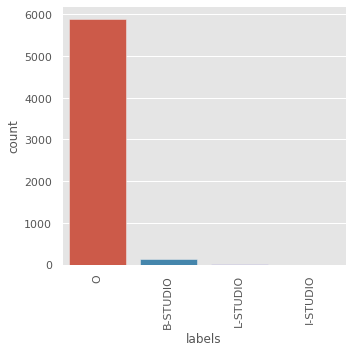

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


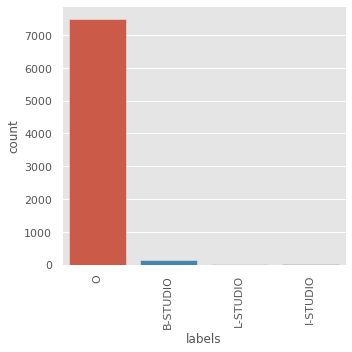

In [ ]:
#Words distribution across Tags (train_data)
plt.figure(figsize=(5, 5))
ax = sn.countplot('labels', data=df_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()


#Words distribution across Tags (dev_data)
plt.figure(figsize=(5, 5))
ax = sn.countplot('labels', data=df_dev)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()


#Words distribution across Tags (test_data)
plt.figure(figsize=(5, 5))
ax = sn.countplot('labels', data=df_test)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


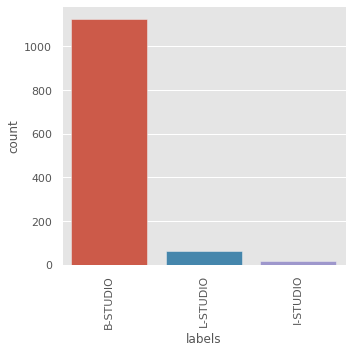

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


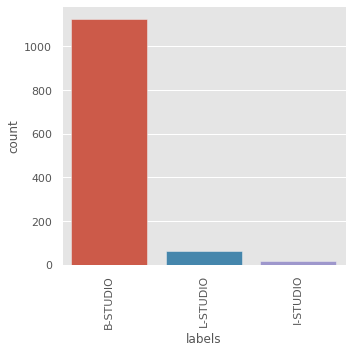

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


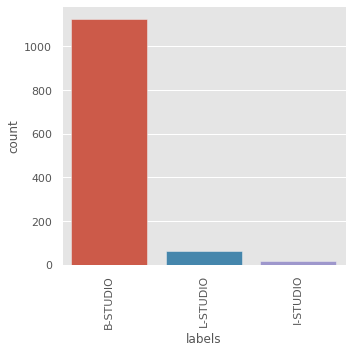

In [ ]:
#Words distribution across Tags without O tag (train_data)
plt.figure(figsize=(5, 5))
ax = sn.countplot('labels', data=df_train.loc[df_train['labels'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

#Words distribution across Tags without O tag (dev_data)
plt.figure(figsize=(5, 5))
ax = sn.countplot('labels', data=df_train.loc[df_train['labels'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

#Words distribution across Tags without O tag (test_data)
plt.figure(figsize=(5, 5))
ax = sn.countplot('labels', data=df_train.loc[df_train['labels'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [ ]:

def plot_labels(df, title=None):
  ds_labels = df["labels"].value_counts(normalize=True)
  ds_labels.sort_index(inplace=True)
  plt.figure(figsize=(5,5))
  ax = ds_labels.plot(kind="bar")
  ax.set_xlabel("Tags")
  ax.set_ylabel("Ratio")
  if title is not None:
    plt.savefig(title + ".png")
  plt.show()

In [ ]:
count_train = df_train["labels"].value_counts(normalize=False)
print(count_train)

count_dev = df_dev["labels"].value_counts(normalize=False)
print(count_dev)

count_test = df_test["labels"].value_counts(normalize=False)
print(count_test)



O           56836
B-STUDIO     1127
L-STUDIO       61
I-STUDIO       16
Name: labels, dtype: int64
O           5896
B-STUDIO     141
L-STUDIO       8
I-STUDIO       1
Name: labels, dtype: int64
O           7501
B-STUDIO     141
L-STUDIO       6
I-STUDIO       2
Name: labels, dtype: int64


------------------------------------------
# **4. Feature Engineering**

**4.1 Vectorization**

The following settings for vectorization were used:



*   Word representation: CountVectorizer;
*   N-grams: unigram & bigram;
*   Minimum document frequency: 5;
*   Convert to lowercase;
*   Try binary counter;

------------------------------------------

In [ ]:
labelencoder = LabelEncoder()
df_train['sentence_id'] = labelencoder.fit_transform(df_train['sentence_id'])
df_dev['sentence_id'] = labelencoder.fit_transform(df_dev['sentence_id'])
df_test['sentence_id'] = labelencoder.fit_transform(df_test['sentence_id'])


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def extract_features(df_train, df_dev, df_test):
  vectorizer = TfidfVectorizer(analyzer='word', 
                               ngram_range=(1, 2),
                               lowercase=True,
                               min_df=5,
                               binary=False)
  X_train = vectorizer.fit_transform(df_train["words"])
  X_dev = vectorizer.transform(df_dev["words"])
  X_test = vectorizer.transform(df_test["words"])
  y_train = df_train["labels"].tolist()
  y_dev = df_dev["labels"].tolist()
  y_test = df_test["labels"].tolist()
  
  return X_train, X_dev, X_test, y_train, y_dev, y_test

X_train, X_dev, X_test, y_train, y_dev, y_test = extract_features(df_train, df_dev, df_test)

-----------------------------------------
**4.2 Test for CountVectorizer (Integer)**

-----------------------------------------

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [ ]:
clf_lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished


LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_depth=None, 
                                min_samples_split=2,
                                min_samples_leaf=10, 
                                max_features="auto", 
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')

In [ ]:
clf_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf_sgd = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(loss='hinge',
                                      penalty='l2',
                                      alpha=30,
                                      max_iter=1000, 
                                      tol=1e-3,
                                      shuffle=True,
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state=0,
                                      learning_rate='optimal',
                                      early_stopping=True,
                                      class_weight='balanced'))



In [ ]:
clf_sgd.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1-- Epoch 1

Norm: 0.06, NNZs: 1197, Bias: -0.006901, T: 52236, Avg. loss: 0.869327
Total training time: 0.01 seconds.Norm: 0.09, NNZs: 1197, Bias: -0.007855, T: 52236, Avg. loss: 0.876020
Total training time: 0.01 seconds.

-- Epoch 2-- Epoch 2

Norm: 0.05, NNZs: 1197, Bias: -0.008046, T: 104472, Avg. loss: 0.875421
Total training time: 0.02 seconds.
Norm: 0.06, NNZs: 1197, Bias: -0.007070, T: 104472, Avg. loss: 0.868542
Total training time: 0.03 seconds.
-- Epoch 3
-- Epoch 3
Norm: 0.05, NNZs: 1197, Bias: -0.008153, T: 156708, Avg. loss: 0.874515
Total training time: 0.04 seconds.
Norm: 0.06, NNZs: 1197, Bias: -0.007169, T: 156708, Avg. loss: 0.868374
Total training time: 0.04 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.05, NNZs: 1197, Bias: -0.008230, T: 208944, Avg. loss: 0.874432
Total training time: 0.06 seconds.
Norm: 0.06, NNZs: 1197, Bias: -0.007239, T: 208944, Avg. loss: 0.868201
Total training time: 0.06 seconds.
-- Epoch 5
-- Epoch 5Norm: 0.05, NNZs: 1197, Bias: -0.0082

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('sgdclassifier',
                 SGDClassifier(alpha=30, average=False, class_weight='balanced',
                               early_stopping=True, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=-1,
                               penalty='l2', power_t=0.5, random_state=0,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=1, warm_start=False))],
         verbose=False)

In [ ]:
from sklearn import svm
clf_svm = svm.SVC()
clf_svm.fit(X_train, y_train)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



---


# **4.1. Experiments and Results**
Machine learning models and transformer-based models will be evaluated.

### **Machine Learning Models**

*   Logistic Regression
*   Random Forest
*   Linear SVM

### **Evaluation Metrics**

*   Precision
*   Recall
*   F1 score
*   Accuracy
*   Confusion matrix

---

In [ ]:
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
  if y_pred is None:
    y_pred = model.predict(X)

  print(label + ' Set')
  print("Accuracy:", accuracy_score(y, y_pred))
  print()

  print(classification_report(y, y_pred, digits=4))
  disp = plot_confusion_matrix(model, X, y, 
                               cmap=plt.cm.Blues, normalize='true')
  plt.savefig(model_name + "_" + label.lower() + ".png")
  plt.show()
  print()

In [ ]:
def evaluate_model(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
  evaluate_model_Xy(model, X_train, y_train, label="Training", model_name=model_name)
  evaluate_model_Xy(model, X_dev, y_dev, label="Validation", model_name=model_name)
  evaluate_model_Xy(model, X_test, y_test, label="Testing", model_name=model_name)

Training Set
Accuracy: 0.6516368022053756

              precision    recall  f1-score   support

    B-STUDIO     0.9111    0.9184    0.9147      1127
    I-STUDIO     0.0007    0.8125    0.0013        16
    L-STUDIO     0.1478    0.7705    0.2480        61
           O     1.0000    0.6462    0.7851     56836

    accuracy                         0.6516     58040
   macro avg     0.5149    0.7869    0.4873     58040
weighted avg     0.9971    0.6516    0.7868     58040



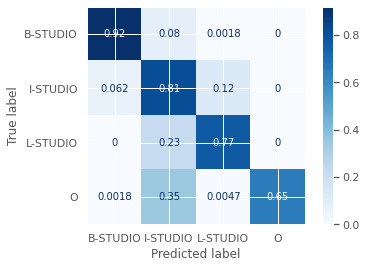


Validation Set
Accuracy: 0.6415812107178299

              precision    recall  f1-score   support

    B-STUDIO     0.9071    0.9007    0.9039       141
    I-STUDIO     0.0005    1.0000    0.0009         1
    L-STUDIO     0.1395    0.7500    0.2353         8
           O     0.9992    0.6352    0.7766      5896

    accuracy                         0.6416      6046
   macro avg     0.5116    0.8215    0.4792      6046
weighted avg     0.9958    0.6416    0.7788      6046



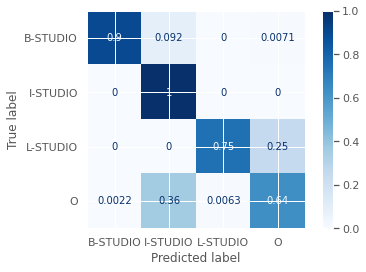


Testing Set
Accuracy: 0.6460130718954248

              precision    recall  f1-score   support

    B-STUDIO     0.8844    0.9220    0.9028       141
    I-STUDIO     0.0008    1.0000    0.0015         2
    L-STUDIO     0.0769    0.5000    0.1333         6
           O     1.0000    0.6408    0.7811      7501

    accuracy                         0.6460      7650
   macro avg     0.4905    0.7657    0.4547      7650
weighted avg     0.9969    0.6460    0.7826      7650



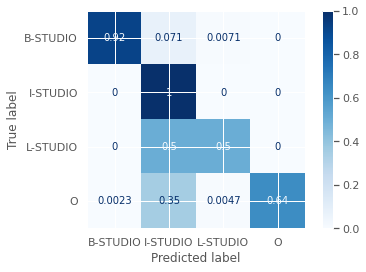

In [ ]:
evaluate_model(clf_lr, model_name="lr_count_int")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    9.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   10.2s finished


Training Set
Accuracy: 0.5450551343900758

              precision    recall  f1-score   support

    B-STUDIO     0.9395    0.8962    0.9173      1127
    I-STUDIO     0.0005    0.7500    0.0009        16
    L-STUDIO     0.1410    0.7049    0.2350        61
           O     1.0000    0.5379    0.6995     56836

    accuracy                         0.5451     58040
   macro avg     0.5202    0.7222    0.4632     58040
weighted avg     0.9976    0.5451    0.7030     58040



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    9.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   10.2s finished


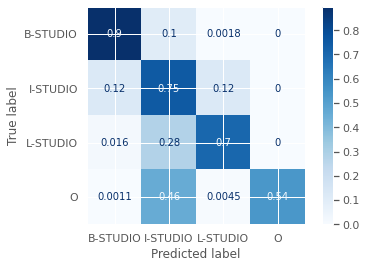

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.1s finished


Validation Set
Accuracy: 0.5509427720807145

              precision    recall  f1-score   support

    B-STUDIO     0.9618    0.8936    0.9265       141
    I-STUDIO     0.0004    1.0000    0.0007         1
    L-STUDIO     0.1429    0.7500    0.2400         8
           O     0.9994    0.5424    0.7032      5896

    accuracy                         0.5509      6046
   macro avg     0.5261    0.7965    0.4676      6046
weighted avg     0.9972    0.5509    0.7076      6046



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.1s finished


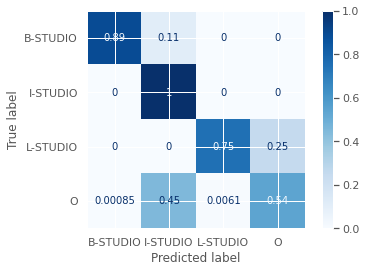

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.4s finished


Testing Set
Accuracy: 0.5598692810457516

              precision    recall  f1-score   support

    B-STUDIO     0.9034    0.9291    0.9161       141
    I-STUDIO     0.0003    0.5000    0.0006         2
    L-STUDIO     0.0526    0.3333    0.0909         6
           O     1.0000    0.5531    0.7123      7501

    accuracy                         0.5599      7650
   macro avg     0.4891    0.5789    0.4300      7650
weighted avg     0.9972    0.5599    0.7154      7650



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.4s finished


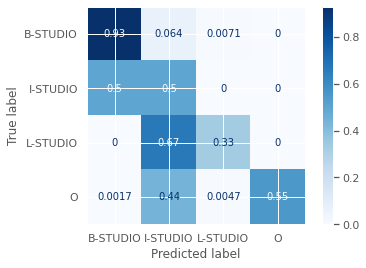

In [ ]:
evaluate_model(clf_rf, model_name="rf")

Training Set
Accuracy: 0.9849069607167471

              precision    recall  f1-score   support

    B-STUDIO     0.9102    0.9175    0.9138      1127
    I-STUDIO     0.0136    0.3750    0.0262        16
    L-STUDIO     0.1088    0.5246    0.1803        61
           O     0.9986    0.9869    0.9927     56836

    accuracy                         0.9849     58040
   macro avg     0.5078    0.7010    0.5283     58040
weighted avg     0.9957    0.9849    0.9901     58040



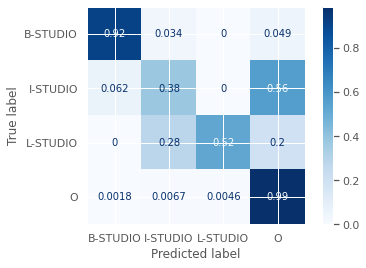


Validation Set
Accuracy: 0.9826331458815746

              precision    recall  f1-score   support

    B-STUDIO     0.9071    0.9007    0.9039       141
    I-STUDIO     0.0222    1.0000    0.0435         1
    L-STUDIO     0.1000    0.5000    0.1667         8
           O     0.9979    0.9852    0.9916      5896

    accuracy                         0.9826      6046
   macro avg     0.5068    0.8465    0.5264      6046
weighted avg     0.9945    0.9826    0.9883      6046



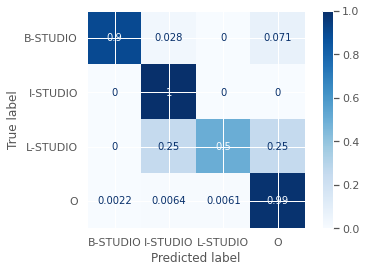


Testing Set
Accuracy: 0.9832679738562091

              precision    recall  f1-score   support

    B-STUDIO     0.8784    0.9220    0.8997       141
    I-STUDIO     0.0143    0.5000    0.0278         2
    L-STUDIO     0.0571    0.3333    0.0976         6
           O     0.9989    0.9851    0.9919      7501

    accuracy                         0.9833      7650
   macro avg     0.4872    0.6851    0.5042      7650
weighted avg     0.9957    0.9833    0.9893      7650



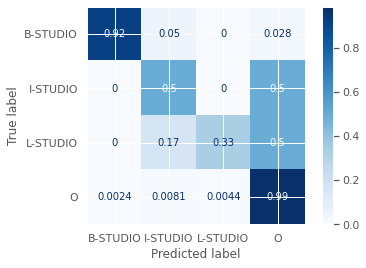

In [ ]:
evaluate_model(clf_sgd, model_name="sgd")

Training Set
Accuracy: 0.9962956581667816



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    B-STUDIO     0.9397    0.9272    0.9335      1127
    I-STUDIO     0.0000    0.0000    0.0000        16
    L-STUDIO     0.5769    0.2459    0.3448        61
           O     0.9976    0.9988    0.9982     56836

    accuracy                         0.9963     58040
   macro avg     0.6286    0.5430    0.5691     58040
weighted avg     0.9958    0.9963    0.9960     58040



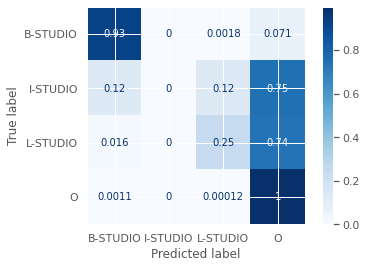


Validation Set
Accuracy: 0.9953688389017532

              precision    recall  f1-score   support

    B-STUDIO     0.9481    0.9078    0.9275       141
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.6667    0.2500    0.3636         8
           O     0.9966    0.9986    0.9976      5896

    accuracy                         0.9954      6046
   macro avg     0.6529    0.5391    0.5722      6046
weighted avg     0.9949    0.9954    0.9950      6046



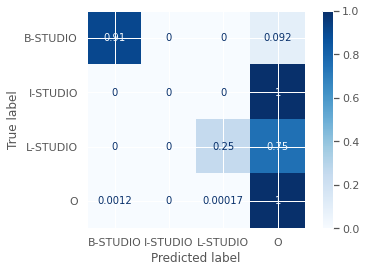


Testing Set
Accuracy: 0.9963398692810458

              precision    recall  f1-score   support

    B-STUDIO     0.9116    0.9504    0.9306       141
    I-STUDIO     0.0000    0.0000    0.0000         2
    L-STUDIO     0.2500    0.1667    0.2000         6
           O     0.9984    0.9981    0.9983      7501

    accuracy                         0.9963      7650
   macro avg     0.5400    0.5288    0.5322      7650
weighted avg     0.9960    0.9963    0.9961      7650



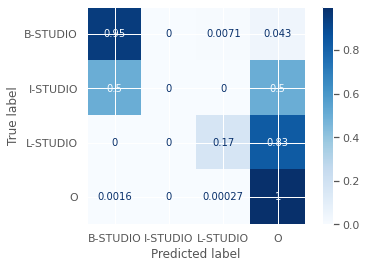

In [ ]:
evaluate_model(clf_svm, model_name="svm")

# 4.2. **Deep Learning**
Transformer-based models including BERT, DistilBERT, RoBERTa, and XLNet will be used in this section.

In [ ]:
label = df_train["labels"].unique().tolist()
print(label)

cuda_available = torch.cuda.is_available()

['O', 'B-STUDIO', 'L-STUDIO', 'I-STUDIO']


### **4.2.1.Evaluation Metrics for Transformers**

In [ ]:
def evaluate_bert_model_one(model, df, label="Training", model_name="model"):
  y = df['labels'].tolist()
  y_pred, raw_outputs = model.predict(df['words'])

  predicted = []
  true = []

  for elem in y_pred:
    for e in elem:
       for k,v in e.items():
         for el in new_dict_true:
          for key, value in el.items():
            if k == key:
              predicted.append(v)
              true.append(value)

  
  print(label + ' Set')
  print("Accuracy:", accuracy_score(true, predicted))
  print()

  print(classification_report(true, predicted, digits=4))
  df_cm = pd.DataFrame(confusion_matrix(true, predicted, normalize='true'), 
                       range(1,5), range(1,5))
  plt.figure(figsize=(6,4))
  ax = sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, square=True)
  ax.set_xlabel('Predicted label')
  ax.set_ylabel('True label')
  plt.savefig(model_name + "_" + label.lower() + ".png")
  plt.show()
  print()

In [ ]:
def evaluate_bert_model(model, model_name="model"):
  #evaluate_bert_model_one(model, df_dev, label="Validation", model_name=model_name)
  evaluate_bert_model_one(model, df_test, label="Testing", model_name=model_name)
  # evaluate_bert_model_one(model, df_train, label="Training", model_name=model_name)

# **4.3. BERT (Bidirectional Encoder Representations)**

### **Tests for Maximum Sequence Level**
max_seq_length: 32 vs. 64. vs 128

In [ ]:
model_bert_base_cased_32 = \
NERModel('bert',
                    'bert-base-cased',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_bert_base_cased_32/",
                          "best_model_dir": "outputs_bert_base_cased_32/best_model/",
                          "max_seq_length": 32,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
model_bert_base_cased_32.train_model(df_train, eval_data = df_dev)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/232 [00:00<?, ?it/s]

(232, 0.06943755905000405)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Testing Set
Accuracy: 0.9976139978791092

              precision    recall  f1-score   support

    B-STUDIO     0.9521    0.9521    0.9521       146
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.0000    0.0000    0.0000         4
           O     0.9985    0.9992    0.9989      7393

    accuracy                         0.9976      7544
   macro avg     0.4876    0.4878    0.4877      7544
weighted avg     0.9970    0.9976    0.9973      7544



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


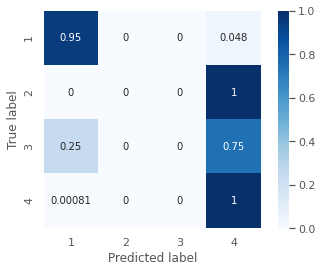

In [ ]:
evaluate_bert_model(model_bert_base_cased_32, model_name="bert_base_cased_32")

In [ ]:
y = df_test['labels'].tolist()
y_pred, raw_outputs = model_bert_base_cased_32.predict(df_test['words'])

predicted = []
true = []


for elem in y_pred:
    for e in elem:
       for k,v in e.items():
         for el in new_dict_true:
          for key, value in el.items():
            if k == key:
              predicted.append(v)
              true.append(value)

 
count_predicted = collections.Counter(predicted)   
count_true = collections.Counter(true)  
print(count_predicted)     
print(count_true) 



  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

In [ ]:
predicted = []
true = []


for elem in y_pred:
    for e in elem:
       for k,v in e.items():
         for el in new_dict_true:
          for key, value in el.items():
            if k == key:
              predicted.append(v)
              true.append(value)

 
count_predicted = collections.Counter(predicted)   
count_true = collections.Counter(true)  
print(count_predicted)     
print(count_true)      

Counter({'O': 7397, 'B-STUDIO': 147})
Counter({'O': 7393, 'B-STUDIO': 146, 'L-STUDIO': 4, 'I-STUDIO': 1})


In [ ]:
score_base_cased_32, model_outputs_bert_cased_32, preds_bert_cased_32 = model_bert_base_cased_32.eval_model(df_test)
print(score_base_cased_32)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.011307216236580922, 'precision': 0.8611111111111112, 'recall': 0.9323308270676691, 'f1_score': 0.8953068592057762}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [ ]:
model_bert_base_cased_64 = \
NERModel('bert',
                    'bert-base-cased',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_bert_base_cased_64/",
                          "best_model_dir": "outputs_bert_base_cased_64/best_model/",
                          "max_seq_length": 64,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
model_bert_base_cased_64.train_model(df_train, eval_data = df_dev)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/232 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(232, 0.07119655010244279)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Testing Set
Accuracy: 0.9974814422057264

              precision    recall  f1-score   support

    B-STUDIO     0.9583    0.9452    0.9517       146
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.0000    0.0000    0.0000         4
           O     0.9982    0.9992    0.9987      7393

    accuracy                         0.9975      7544
   macro avg     0.4891    0.4861    0.4876      7544
weighted avg     0.9968    0.9975    0.9971      7544



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


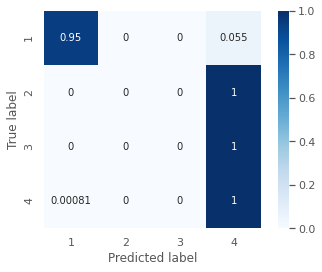

In [ ]:
evaluate_bert_model(model_bert_base_cased_64, model_name="bert_base_cased_64")

In [ ]:
score_base_cased_64, model_outputs_bert_cased_64, preds_bert_cased_64 = model_bert_base_cased_64.eval_model(df_test)
print(score_base_cased_64)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.009750212606346488, 'precision': 0.8933333333333333, 'recall': 0.9571428571428572, 'f1_score': 0.9241379310344828}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [ ]:
y = df_test['labels'].tolist()
y_pred, raw_outputs = model_bert_base_cased_64.predict(df_test['words'])

predicted = []
true = []


for elem in y_pred:
    for e in elem:
       for k,v in e.items():
         for el in new_dict_true:
          for key, value in el.items():
            if k == key:
              predicted.append(v)
              true.append(value)

 
count_predicted = collections.Counter(predicted)   
count_true = collections.Counter(true)  
print(count_predicted)     
print(count_true) 



  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Counter({'O': 7400, 'B-STUDIO': 144})
Counter({'O': 7393, 'B-STUDIO': 146, 'L-STUDIO': 4, 'I-STUDIO': 1})


In [ ]:
model_bert_base_cased_128 = \
NERModel('bert',
                    'bert-base-cased',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_bert_base_cased_128/",
                          "best_model_dir": "outputs_bert_base_cased_128/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
model_bert_base_cased_128.train_model(df_train, eval_data = df_dev)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/232 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(232, 0.08085294641970339)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Testing Set
Accuracy: 0.9978791092258749

              precision    recall  f1-score   support

    B-STUDIO     0.9589    0.9589    0.9589       146
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.0000    0.0000    0.0000         4
           O     0.9986    0.9993    0.9990      7393

    accuracy                         0.9979      7544
   macro avg     0.4894    0.4896    0.4895      7544
weighted avg     0.9972    0.9979    0.9975      7544



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


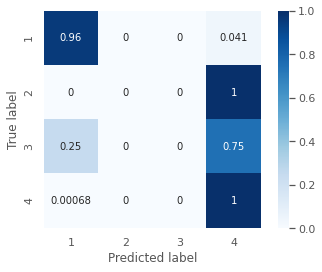

In [ ]:
evaluate_bert_model(model_bert_base_cased_128, model_name="bert_base_cased_128")

In [ ]:
y = df_test['labels'].tolist()
y_pred, raw_outputs = model_bert_base_cased_128.predict(df_test['words'])

predicted = []
true = []


for elem in y_pred:
    for e in elem:
       for k,v in e.items():
         for el in new_dict_true:
          for key, value in el.items():
            if k == key:
              predicted.append(v)
              true.append(value)

 
count_predicted = collections.Counter(predicted)   
count_true = collections.Counter(true)  
print(count_predicted)     
print(count_true) 



  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Counter({'O': 7398, 'B-STUDIO': 146})
Counter({'O': 7393, 'B-STUDIO': 146, 'L-STUDIO': 4, 'I-STUDIO': 1})


In [ ]:
score_base_cased_128, model_outputs_bert_cased_128, preds_bert_cased_64 = model_bert_base_cased_128.eval_model(df_test)
print(score_base_cased_128)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.008940831767700975, 'precision': 0.8933333333333333, 'recall': 0.950354609929078, 'f1_score': 0.9209621993127147}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [ ]:
del model_bert_base_cased_128



---


# **4.3.1. Cased Large BERT**


---



In [ ]:
model_bert_large_cased = \
NERModel('bert',
                    'bert-large-cased',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_bert_large_cased/",
                          "best_model_dir": "outputs_bert_large_cased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-c

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
model_bert_large_cased.train_model(df_train, eval_data = df_dev)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/232 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(232, 0.05436534909814986)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Testing Set
Accuracy: 0.9974814422057264

              precision    recall  f1-score   support

    B-STUDIO     0.9521    0.9521    0.9521       146
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.0000    0.0000    0.0000         4
           O     0.9984    0.9991    0.9987      7393

    accuracy                         0.9975      7544
   macro avg     0.4876    0.4878    0.4877      7544
weighted avg     0.9968    0.9975    0.9972      7544



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


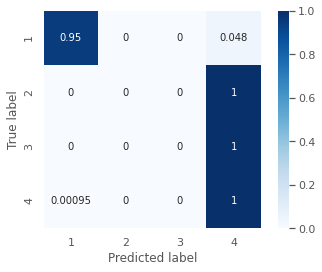

In [ ]:
evaluate_bert_model(model_bert_large_cased, model_name="model_bert_large_cased")

In [ ]:
score_base_cased_large, model_outputs_bert_cased_large, preds_bert_cased_large = model_bert_large_cased.eval_model(df_test)
print(score_base_cased_large)

Running Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.00876890993662281, 'precision': 0.9006622516556292, 'recall': 0.9645390070921985, 'f1_score': 0.9315068493150684}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [ ]:
y = df_test['labels'].tolist()
y_pred, raw_outputs = model_bert_large_cased.predict(df_test['words'])

predicted = []
true = []


for elem in y_pred:
    for e in elem:
       for k,v in e.items():
         for el in new_dict_true:
          for key, value in el.items():
            if k == key:
              predicted.append(v)
              true.append(value)

 
count_predicted = collections.Counter(predicted)   
count_true = collections.Counter(true)  
print(count_predicted)     
print(count_true) 



  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Counter({'O': 7398, 'B-STUDIO': 146})
Counter({'O': 7393, 'B-STUDIO': 146, 'L-STUDIO': 4, 'I-STUDIO': 1})


In [ ]:
del model_bert_large_cased


---
# **4.3.2. Uncased BERT**


---






In [ ]:
model_bert_base_uncased_128 = \
NERModel('bert',
                    'bert-base-uncased',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_bert_base_uncased/",
                          "best_model_dir": "outputs_bert_base_uncased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": True,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
model_bert_base_uncased_128.train_model(df_train, eval_data = df_dev)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/232 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


(232,
 {'eval_loss': [0.332902061752975],
  'f1_score': [0.0],
  'global_step': [232],
  'precision': [0.0],
  'recall': [0.0],
  'train_loss': [0.00287588220089674]})

  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Testing Set
Accuracy: 0.9799840933191941

              precision    recall  f1-score   support

    B-STUDIO     0.0000    0.0000    0.0000       146
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.0000    0.0000    0.0000         4
           O     0.9800    1.0000    0.9899      7393

    accuracy                         0.9800      7544
   macro avg     0.2450    0.2500    0.2475      7544
weighted avg     0.9604    0.9800    0.9701      7544



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


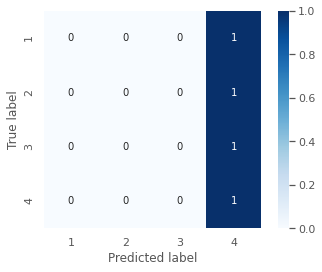

In [ ]:
evaluate_bert_model(model_bert_base_uncased_128, model_name="bert_base_uncased_128")

In [ ]:
score_base_uncased_128, model_outputs_bert_uncased_128, preds_bert_uncased_128 = model_bert_base_uncased_128.eval_model(df_test)
print(score_base_uncased_128)

Running Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.029344503469844112, 'precision': 0.8796992481203008, 'recall': 0.8297872340425532, 'f1_score': 0.854014598540146}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))




---


# **4.4. DistilBERT**
### **4.4.1. Uncased DistilBERT**
---



In [ ]:
model_distilbert_base_uncased = \
NERModel('distilbert', 
                    'distilbert-base-uncased', 
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_distilbert_base_uncased/",
                          "best_model_dir": "outputs_distilbert_base_uncased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN t

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
model_distilbert_base_uncased.train_model(df_train, eval_data = df_dev)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/232 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(232, 0.12367589372322606)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/957 [00:00<?, ?it/s]

Testing Set
Accuracy: 0.9799840933191941

              precision    recall  f1-score   support

    B-STUDIO     0.0000    0.0000    0.0000       146
    I-STUDIO     0.0000    0.0000    0.0000         1
    L-STUDIO     0.0000    0.0000    0.0000         4
           O     0.9800    1.0000    0.9899      7393

    accuracy                         0.9800      7544
   macro avg     0.2450    0.2500    0.2475      7544
weighted avg     0.9604    0.9800    0.9701      7544



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


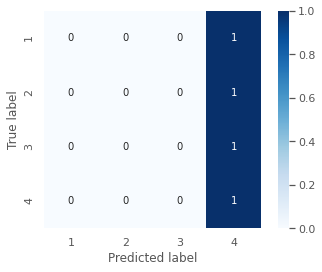

In [ ]:
evaluate_bert_model(model_distilbert_base_uncased, model_name="model_distilbert_base_uncased")

In [ ]:
score_model_distilbert_base_uncased, model_outputs_distilbert_base_uncased, preds_distilbert_base_uncased = model_distilbert_base_uncased.eval_model(df_test)
print(score_base_uncased_128)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/59 [00:00<?, ?it/s]

{'eval_loss': 0.029344503469844112, 'precision': 0.8796992481203008, 'recall': 0.8297872340425532, 'f1_score': 0.854014598540146}


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: L-STUDIO seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [ ]:
del model_distilbert_base_uncased




---


# **4.4.2. Cased DistilBERT**


---



In [ ]:
model_distilbert_base_cased = \
NERModel('distilbert', 
                    'distilbert-base-cased', 
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_distilbert_base_cased/",
                          "best_model_dir": "outputs_distilbert_base_cased/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this 

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
model_distilbert_base_cased.train_model(df_train, eval_data = df_dev)

In [ ]:
evaluate_bert_model(model_distilbert_base_cased, model_name="model_distilbert_base_cased")

In [ ]:
score_model_distilbert_base_cased, model_outputs_distilbert_base_cased, preds_distilbert_base_cased = model_distilbert_base_cased.eval_model(df_test)
print(score_model_distilbert_base_cased)

In [ ]:
y = df_test['labels'].tolist()
y_pred, raw_outputs = model_distilbert_base_cased.predict(df_test['words'])

predicted = []
true = []


for elem in y_pred:
    for e in elem:
       for k,v in e.items():
         for el in new_dict_true:
          for key, value in el.items():
            if k == key:
              predicted.append(v)
              true.append(value)

 
count_predicted = collections.Counter(predicted)   
count_true = collections.Counter(true)  
print(count_predicted)     
print(count_true) 




---


# **4.5. RoBERTa**



---



In [ ]:
model_roberta_base_128 = \
NERModel('roberta', 
                    'roberta-base',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_roberta_base/",
                          "best_model_dir": "outputs_roberta_base/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 10000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 10000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

In [ ]:
model_roberta_base_128.train_model(df_train, eval_data = df_dev)

In [ ]:
evaluate_bert_model(model_roberta_base_128, model_name="model_roberta_base_128")

In [ ]:
score_model_roberta_base_128, model_outputs_roberta_base_128, preds_roberta_base_128 = model_roberta_base_128.eval_model(df_test)
print(score_model_roberta_base_128)

In [ ]:
y = df_test['labels'].tolist()
y_pred, raw_outputs = model_roberta_base_128.predict(df_test['words'])

predicted = []
true = []


for elem in y_pred:
    for e in elem:
       for k,v in e.items():
         for el in new_dict_true:
          for key, value in el.items():
            if k == key:
              predicted.append(v)
              true.append(value)

 
count_predicted = collections.Counter(predicted)   
count_true = collections.Counter(true)  
print(count_predicted)     
print(count_true) 


In [ ]:
model_roberta_base_64 = \
NERModel('roberta', 
                    'roberta-base',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_roberta_base/",
                          "best_model_dir": "outputs_roberta_base/best_model/",
                          "max_seq_length": 64,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 10000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 10000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

In [ ]:
model_roberta_base_64.train_model(df_train, eval_data = df_dev)

In [ ]:
evaluate_bert_model(model_roberta_base_64, model_name="model_roberta_base_64")

In [ ]:
score_model_roberta_base_64, model_outputs_roberta_base_64, preds_roberta_base_64 = model_roberta_base_64.eval_model(df_test)
print(score_model_roberta_base_64)

In [ ]:
y = df_test['labels'].tolist()
y_pred, raw_outputs = model_roberta_base_64.predict(df_test['words'])

predicted = []
true = []


for elem in y_pred:
    for e in elem:
       for k,v in e.items():
         for el in new_dict_true:
          for key, value in el.items():
            if k == key:
              predicted.append(v)
              true.append(value)

 
count_predicted = collections.Counter(predicted)   
count_true = collections.Counter(true)  
print(count_predicted)     
print(count_true) 


In [ ]:
model_roberta_base_32 = \
NERModel('roberta', 
                    'roberta-base',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_roberta_base/",
                          "best_model_dir": "outputs_roberta_base/best_model/",
                          "max_seq_length": 32,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 10000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 10000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

In [ ]:
model_roberta_base_32.train_model(df_train, eval_data = df_dev)

In [ ]:
evaluate_bert_model(model_roberta_base_32, model_name="model_roberta_base_32")

In [ ]:
score_model_roberta_base_32, model_outputs_roberta_base_32, preds_roberta_base_32 = model_roberta_base_32.eval_model(df_test)
print(score_model_roberta_base_32)

In [ ]:
y = df_test['labels'].tolist()
y_pred, raw_outputs = model_roberta_base_32.predict(df_test['words'])

predicted = []
true = []


for elem in y_pred:
    for e in elem:
       for k,v in e.items():
         for el in new_dict_true:
          for key, value in el.items():
            if k == key:
              predicted.append(v)
              true.append(value)

 
count_predicted = collections.Counter(predicted)   
count_true = collections.Counter(true)  
print(count_predicted)     
print(count_true) 


In [ ]:
model_roberta_base_16 = \
NERModel('roberta', 
                    'roberta-base',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_roberta_base/",
                          "best_model_dir": "outputs_roberta_base/best_model/",
                          "max_seq_length": 16,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 10000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

In [ ]:
model_roberta_base_16.train_model(df_train, eval_data = df_dev)

In [ ]:
evaluate_bert_model(model_roberta_base_16, model_name="model_roberta_base_16")

In [ ]:
score_model_roberta_base_16, model_outputs_roberta_base_16, preds_roberta_base_16 = model_roberta_base_16.eval_model(df_test)
print(score_model_roberta_base_16)

In [ ]:
model_roberta_base_large = \
NERModel('roberta', 
                    'roberta-large',
                    labels=label,
                    use_cuda=cuda_available,
                    args={"output_dir": "outputs_roberta_base/",
                          "best_model_dir": "outputs_roberta_base/best_model/",
                          "max_seq_length": 32,
                          "train_batch_size": 16,
                          "num_train_epochs": 1,
                          "logging_steps": 100,
                          "evaluate_during_training": False,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": False,
                          "save_eval_checkpoints": False,
                          "save_steps": 10000,
                          "save_model_every_epoch": True,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False})

In [ ]:
model_roberta_base_large.train_model(df_train, eval_data = df_dev)

In [ ]:
evaluate_bert_model(model_roberta_base_large, model_name="model_roberta_base_large")

In [ ]:
score_model_roberta_base_large, model_outputs_roberta_base_large, preds_roberta_base_large = model_roberta_base_large.eval_model(df_test)
print(score_model_roberta_base_large)

In [ ]:
y = df_test['labels'].tolist()
y_pred, raw_outputs = model_roberta_base_large.predict(df_test['words'])

predicted = []
true = []


for elem in y_pred:
    for e in elem:
       for k,v in e.items():
         for el in new_dict_true:
          for key, value in el.items():
            if k == key:
              predicted.append(v)
              true.append(value)

 
count_predicted = collections.Counter(predicted)   
count_true = collections.Counter(true)  
print(count_predicted)     
print(count_true) 


In [ ]:
y = df_test['labels'].tolist()
y_pred, raw_outputs = model_roberta_base_32.predict(df_test['words'])

predicted = []
true = []


for elem in y_pred:
    for e in elem:
       for k,v in e.items():
         for el in new_dict_true:
          for key, value in el.items():
            if k == key:
              predicted.append(v)
              true.append(value)

 
count_predicted = collections.Counter(predicted)   
count_true = collections.Counter(true)  
print(count_predicted)     
print(count_true) 


# **5. Test of the Best Model on a new Data**

In [ ]:
test_text = ["1. TriStar Pictures And Entertainment One’s Romantic Comedy, Happiest Season, Starring Kristen Stewart, To Stream Exclusively On Hulu In The U.S. This Holiday Season." ,
            "2. Sony Pictures Television’s Gemstone Studios Announces Finalists In Rising Storytellers Search." ,
            "3. 20th Century Fox is one of the Big Six studios." ,
            "4. NBCUniversal is primarily involved in the media and entertainment industry." ,
            "5. A legendary producer and global distributor of filmed entertainment since 1912, Paramount Pictures' library consists of more than 1,000 film titles with rights to an additional 2,500, featuring films by Hollywood's most respected filmmakers." ,
            "6. Create your profile using your resume, LinkedIn, Facebook, or Google+ profile." ,
            "7. To view all open jobs at ViacomCBS, click here." ,
            "8. Universal Pictures is owned by Comcast through its subsidiary NBCUniversal." ,
            "9. Lionsgate's Motion Picture Group encompasses eight film labels and more than 40 feature film releases a year." ,
            "10. Metro-Goldwyn-Mayer Studios Inc is an American media company, involved primarily in the production and distribution of feature films and television programs." ,
            "11. New Line Productions, Inc., d/b/a New Line Cinema, is an American film production studio and a label of the Warner Bros. Pictures Group division." ,
            "12.  Focus Features along with Sight Unseen, Makeready and Hillman Grad Productions have announced plans to begin production next year on A.V. Rockwell’s A Thousand and One. " ,
            "13. Capital Motion Picture Group has picked up North American and U.K. rights to Cold War thriller “The Man on the Other Side,” directed by Marcus Lim." ,
            "14. Watch Netflix movies & TV shows online or stream right to your smart TV, game console, PC, Mac, mobile, tablet and more." ,
            "15. Warner Bros. Entertainment was founded in 1923 and has created some of the best movies which have innovated the industry, such as The Jazz Singer introducing synchronized sound."
]



In [ ]:
predictions, raw_outputs = model_roberta_base_32.predict(test_text)

In [ ]:
predictions